In [1]:
import copy
from argparse import Namespace
import numpy as np
import matplotlib.pyplot as plt

from bax.models.simple_gp import SimpleGp
from bax.alg.algorithms import Dijkstras
from bax.acq.acqoptimize import AcqOptimizer

from typing import List
from bax.util.graph import Vertex, make_vertices, make_edges, farthest_pair, edges_of_path, positions_of_path

import neatplot
neatplot.set_style('fonts')

In [2]:
# Set random seed
seed = 0
np.random.seed(seed)

In [3]:
# make a grid

g = 10
x1, x2 = np.meshgrid(np.linspace(-1, 1, g), np.linspace(-1, 1, g))
positions = np.stack([x1.flatten(), x2.flatten()], axis=-1)
n = len(positions)

has_edge = [[False for _ in range(n)] for _ in range(n)]
for i in range(n):
    for j in range(i + 1, n):
        if ((abs(i - j) == 1) and (j % g != 0)):
            has_edge[i][j] = True
        elif (abs(i - j) == g):
            has_edge[i][j] = True
        else:
            has_edge[i][j] = False
has_edge = np.array(has_edge)

In [4]:
has_edge

array([[False,  True, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False, False]])

In [5]:
vertices = make_vertices(positions, has_edge)

In [6]:
vertices[0]

(0, [1, 10])

In [7]:
edges = make_edges(vertices)

In [8]:
# make a graph
def l2_dist(u: Vertex, v: Vertex):
    return np.sqrt(np.sum((u.position - v.position)**2))

start, goal = farthest_pair(vertices, distance_func=l2_dist)

In [9]:
def cost_func(u: Vertex, v: Vertex):
    # TODO: make this an input to Dijstra Algorithm
    u_pos, v_pos = u.position, v.position
    fu, fv = f(u_pos), f(v_pos)
    return abs(fu - fv)

def cost_of_path(path, cost_func):
    cost = 0
    for i in range(len(path) - 1):
        cost += cost_func(path[i], path[i+1])
    return cost

In [10]:
# Set function
f = lambda x: x[0]**2 + x[1]**2

# Set data for model
data = Namespace()
data.x = []
data.y = [f(x) for x in data.x]

# Set model as a GP
gp_params = {'ls': 1.0, 'alpha': 1.0, 'sigma': 1e-2}
model = SimpleGp(gp_params)
model.set_data(data)

# Set algorithm
algo = Dijkstras({
    'start': start,
    'goal': goal,
    'vertices': vertices})

#x_test = positions # input points to maximize acquisition function over

*[INFO] SimpleGp with params=Namespace(alpha=1.0, kernel=<function kern_exp_quad at 0x7f9733280430>, ls=1.0, name='SimpleGp', sigma=0.01)
*[INFO] Dijkstras with params=Namespace(goal=(99, [89, 98]), name='Dijkstras', start=(0, [1, 10]), vertices=[(0, [1, 10]), (1, [0, 2, 11]), (2, [1, 3, 12]), (3, [2, 4, 13]), (4, [3, 5, 14]), (5, [4, 6, 15]), (6, [5, 7, 16]), (7, [6, 8, 17]), (8, [7, 9, 18]), (9, [8, 19]), (10, [0, 11, 20]), (11, [1, 10, 12, 21]), (12, [2, 11, 13, 22]), (13, [3, 12, 14, 23]), (14, [4, 13, 15, 24]), (15, [5, 14, 16, 25]), (16, [6, 15, 17, 26]), (17, [7, 16, 18, 27]), (18, [8, 17, 19, 28]), (19, [9, 18, 29]), (20, [10, 21, 30]), (21, [11, 20, 22, 31]), (22, [12, 21, 23, 32]), (23, [13, 22, 24, 33]), (24, [14, 23, 25, 34]), (25, [15, 24, 26, 35]), (26, [16, 25, 27, 36]), (27, [17, 26, 28, 37]), (28, [18, 27, 29, 38]), (29, [19, 28, 39]), (30, [20, 31, 40]), (31, [21, 30, 32, 41]), (32, [22, 31, 33, 42]), (33, [23, 32, 34, 43]), (34, [24, 33, 35, 44]), (35, [25, 34, 36, 4

In [29]:
from matplotlib.collections import LineCollection as LC


def plot_path(ax, path, path_color=(0, 0, 0, 1.), linewidths=2, linestyle="dotted", plot_vertices=False):
    # plot path taken
    path_lines = edges_of_path(path)
    path_lc = LC(path_lines, colors=[path_color] * len(path_lines), linewidths=linewidths, linestyle=linestyle)
    ax.add_collection(path_lc)
    
    # plot visited vertices
    if plot_vertices:
        ax.scatter(*positions_of_path(path).T, color=(0, 0, 0, 1))
    return

def plot_vertices(ax, vertices):
    ax.scatter(*positions_of_path(vertices).T, color=(0, 0, 0, 1))
    return

def plot_graph(ax, edges, start: Vertex, goal: Vertex):
    # plot edges
    color = (0.75, 0.75, 0.75, 0.1)
    lc = LC(edges, colors=[color] * len(edges), linewidths=1.0)
    ax.add_collection(lc)

    # plot vertices
    ax.scatter(*positions.T, color=(0, 0, 0, 1), facecolors='none')

    # plot start and goal vertices
    ax.scatter(*start.position, color='g', label="start", s=100)
    ax.scatter(*goal.position, color='r', label="goal", s=100)
    
    ax.grid(False)
    ax.legend()
    return

def plot_progress(edges, start: Vertex, goal: Vertex, path: List[Vertex], plot_vertices=False):
    fig, ax = plt.subplots(figsize=(4, 4))
    plot_graph(ax, edges, start, goal)
    #plot_path(ax, path, plot_vertices=plot_vertices)
    return fig, ax

In [30]:
def possible_steps(vertex: Vertex):
    neighbors = vertex.neighbors
    possible_positions = np.stack([n.position for n in neighbors])
    return possible_positions

*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 100 vertices with estimated cost 3.510734770339252
Found goal after visiting 100 vertices with estimated cost 3.772117950960353
Found goal after visiting 100 vertices with estimated cost 3.7785548862349136
Found goal after visiting 100 vertices with estimated cost 3.2716321755646196
Found goal after visiting 100 vertices with estimated cost 3.7353124058030893
Found goal after visiting 100 vertices with estimated cost 3.821389754338871
Found goal after visiting 100 vertices with estimated cost 3.4326207666831614
Found goal after visiting 100 vertices with estimated cost 3.658062657842687
Found goal after visiting 100 vertices with estimated cost 3.425391449706063
Found goal after visiting 99 vertices with estimated cost 3.440997126666516
*[TIME] [Sample 10 execution paths] Elapsed: 33.57 seconds
*[TIME] [Pre-compute acquisition 

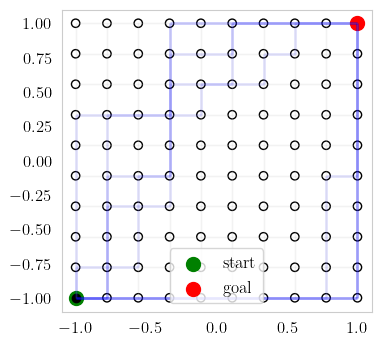

Acq optimizer x_next = (7, [6, 8, 17])
Finished iter i = 0
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 100 vertices with estimated cost 3.413659170690736
Found goal after visiting 100 vertices with estimated cost 3.628072929246793
Found goal after visiting 100 vertices with estimated cost 3.565788063821868
Found goal after visiting 100 vertices with estimated cost 3.4319801753842114
Found goal after visiting 100 vertices with estimated cost 3.5666371952373987
Found goal after visiting 100 vertices with estimated cost 3.585737188986997
Found goal after visiting 99 vertices with estimated cost 3.418670880231652
Found goal after visiting 100 vertices with estimated cost 3.414490325270074
Found goal after visiting 100 vertices with estimated cost 3.5916966877320515
Found goal after visiting 100 vertices with estimated cost 3.3659668692279805
*[TIME] [Sample 10 execution path

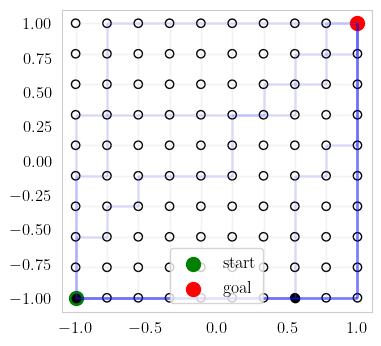

Acq optimizer x_next = (94, [84, 93, 95])
Finished iter i = 1
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 100 vertices with estimated cost 3.2740784336584765
Found goal after visiting 100 vertices with estimated cost 3.603216731018799
Found goal after visiting 100 vertices with estimated cost 3.5787908545395757
Found goal after visiting 99 vertices with estimated cost 3.417290532294241
Found goal after visiting 99 vertices with estimated cost 2.972494115392899
Found goal after visiting 99 vertices with estimated cost 3.2083710660736786
Found goal after visiting 100 vertices with estimated cost 3.365080478776661
Found goal after visiting 100 vertices with estimated cost 3.165323735952967
Found goal after visiting 100 vertices with estimated cost 3.2079741939315953
Found goal after visiting 100 vertices with estimated cost 3.1258221924145886
*[TIME] [Sample 10 execution pa

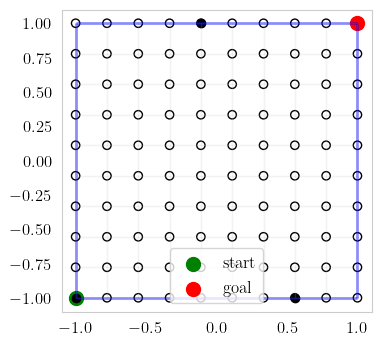

Acq optimizer x_next = (61, [51, 60, 62, 71])
Finished iter i = 2
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 100 vertices with estimated cost 3.5686816833278585
Found goal after visiting 100 vertices with estimated cost 3.3984242945083163
Found goal after visiting 100 vertices with estimated cost 3.3818598862102003
Found goal after visiting 100 vertices with estimated cost 3.324470445717391
Found goal after visiting 100 vertices with estimated cost 3.3050209526138845
Found goal after visiting 100 vertices with estimated cost 3.2828166013637823
Found goal after visiting 100 vertices with estimated cost 3.4595101151955747
Found goal after visiting 100 vertices with estimated cost 3.3200086756349236
Found goal after visiting 100 vertices with estimated cost 3.526741148274869
Found goal after visiting 100 vertices with estimated cost 3.481611227755815
*[TIME] [Sample 10 exe

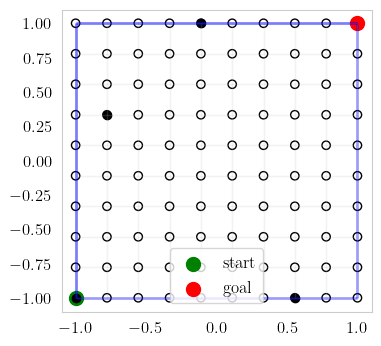

Acq optimizer x_next = (75, [65, 74, 76, 85])
Finished iter i = 3
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 100 vertices with estimated cost 3.503095317907046
Found goal after visiting 99 vertices with estimated cost 3.201845742783336
Found goal after visiting 100 vertices with estimated cost 3.4900772209352984
Found goal after visiting 100 vertices with estimated cost 3.5489575028218727
Found goal after visiting 100 vertices with estimated cost 3.3132031270842353
Found goal after visiting 100 vertices with estimated cost 3.6740711974064864
Found goal after visiting 100 vertices with estimated cost 3.5080009333460467
Found goal after visiting 100 vertices with estimated cost 3.5957584404047784
Found goal after visiting 100 vertices with estimated cost 3.5200606227869495
Found goal after visiting 100 vertices with estimated cost 3.4098176805561464
*[TIME] [Sample 10 exe

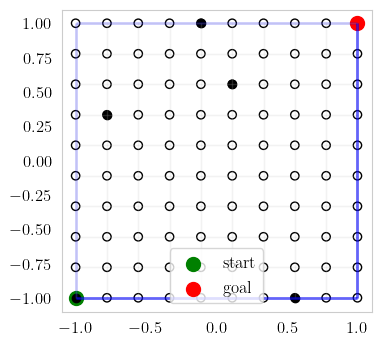

Acq optimizer x_next = (25, [15, 24, 26, 35])
Finished iter i = 4
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 100 vertices with estimated cost 3.374626263780831
Found goal after visiting 98 vertices with estimated cost 2.912684578486222
Found goal after visiting 100 vertices with estimated cost 3.6139234054588876
Found goal after visiting 100 vertices with estimated cost 3.3395856215666426
Found goal after visiting 100 vertices with estimated cost 3.3937606004638097
Found goal after visiting 100 vertices with estimated cost 3.393536291850488
Found goal after visiting 100 vertices with estimated cost 3.477595201769769
Found goal after visiting 100 vertices with estimated cost 3.447896106024548
Found goal after visiting 100 vertices with estimated cost 3.4934664828885458
Found goal after visiting 100 vertices with estimated cost 3.4520094829282506
*[TIME] [Sample 10 execut

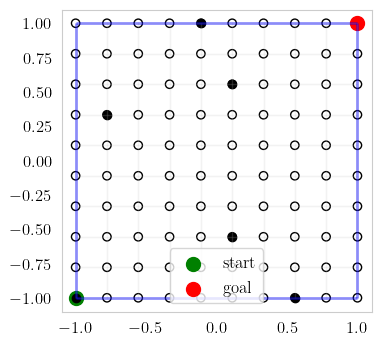

Acq optimizer x_next = (49, [39, 48, 59])
Finished iter i = 5
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 100 vertices with estimated cost 3.4585701174476644
Found goal after visiting 100 vertices with estimated cost 3.5791714355055078
Found goal after visiting 100 vertices with estimated cost 3.408843377343683
Found goal after visiting 100 vertices with estimated cost 3.4503981610850922
Found goal after visiting 100 vertices with estimated cost 3.409656872765942
Found goal after visiting 100 vertices with estimated cost 3.393201084502742
Found goal after visiting 100 vertices with estimated cost 3.4010196666124397
Found goal after visiting 100 vertices with estimated cost 3.5128420152000603
Found goal after visiting 100 vertices with estimated cost 3.6498924884544106
Found goal after visiting 100 vertices with estimated cost 3.4045238453372835
*[TIME] [Sample 10 executi

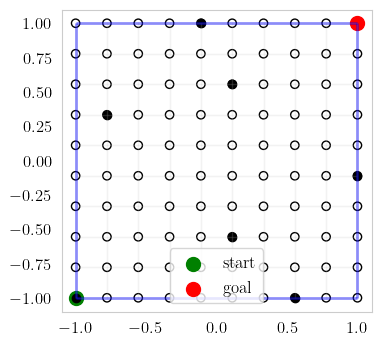

Acq optimizer x_next = (1, [0, 2, 11])
Finished iter i = 6
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 100 vertices with estimated cost 3.4632004321898373
Found goal after visiting 100 vertices with estimated cost 3.494287645927802
Found goal after visiting 100 vertices with estimated cost 3.6198535024419667
Found goal after visiting 100 vertices with estimated cost 3.5801191212112444
Found goal after visiting 100 vertices with estimated cost 3.5391952266586397
Found goal after visiting 100 vertices with estimated cost 3.536610702716393
Found goal after visiting 100 vertices with estimated cost 3.448469944335522
Found goal after visiting 100 vertices with estimated cost 3.5680704525248137
Found goal after visiting 100 vertices with estimated cost 3.5831479344025903
Found goal after visiting 100 vertices with estimated cost 3.499163228250351
*[TIME] [Sample 10 execution p

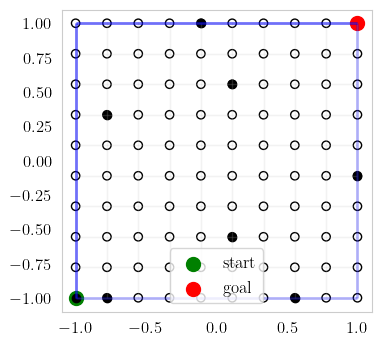

Acq optimizer x_next = (98, [88, 97, 99])
Finished iter i = 7
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 100 vertices with estimated cost 3.475098355720097
Found goal after visiting 100 vertices with estimated cost 3.6147982680028363
Found goal after visiting 100 vertices with estimated cost 3.5808198310202073
Found goal after visiting 100 vertices with estimated cost 3.6877711765160077
Found goal after visiting 100 vertices with estimated cost 3.595528243679638
Found goal after visiting 100 vertices with estimated cost 3.560995349404159
Found goal after visiting 100 vertices with estimated cost 3.5559030954480737
Found goal after visiting 100 vertices with estimated cost 3.575784187364661
Found goal after visiting 100 vertices with estimated cost 3.604696218943989
Found goal after visiting 100 vertices with estimated cost 3.5480538087130027
*[TIME] [Sample 10 execution

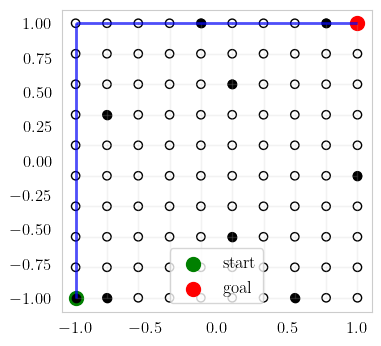

Acq optimizer x_next = (91, [81, 90, 92])
Finished iter i = 8
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 100 vertices with estimated cost 3.598851877918123
Found goal after visiting 100 vertices with estimated cost 3.659235121530028
Found goal after visiting 100 vertices with estimated cost 3.650695667231749
Found goal after visiting 100 vertices with estimated cost 3.582103730990336
Found goal after visiting 100 vertices with estimated cost 3.6439392689759265
Found goal after visiting 100 vertices with estimated cost 3.6355099231388497
Found goal after visiting 100 vertices with estimated cost 3.704065027596504
Found goal after visiting 100 vertices with estimated cost 3.688182719201393
Found goal after visiting 100 vertices with estimated cost 3.5118972289713355
Found goal after visiting 100 vertices with estimated cost 3.682565869753301
*[TIME] [Sample 10 execution p

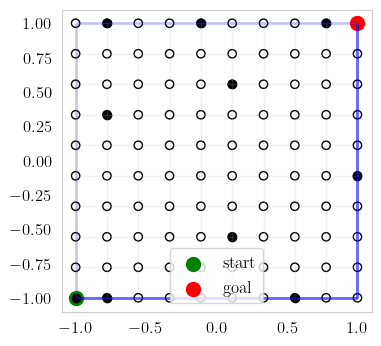

Acq optimizer x_next = (46, [36, 45, 47, 56])
Finished iter i = 9
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 100 vertices with estimated cost 3.7923752083343505
Found goal after visiting 100 vertices with estimated cost 3.6422749459613235
Found goal after visiting 100 vertices with estimated cost 3.6806933474836345
Found goal after visiting 100 vertices with estimated cost 3.6981190567797046
Found goal after visiting 100 vertices with estimated cost 3.637461524083842
Found goal after visiting 100 vertices with estimated cost 3.7113522295919803
Found goal after visiting 100 vertices with estimated cost 3.711247612531742
Found goal after visiting 100 vertices with estimated cost 3.643244980363869
Found goal after visiting 100 vertices with estimated cost 3.596111106957895
Found goal after visiting 100 vertices with estimated cost 3.610736102482634
*[TIME] [Sample 10 execu

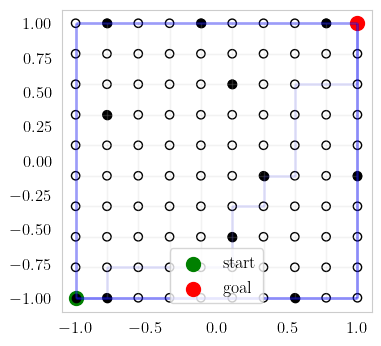

Acq optimizer x_next = (42, [32, 41, 43, 52])
Finished iter i = 10
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 100 vertices with estimated cost 3.682082643217643
Found goal after visiting 100 vertices with estimated cost 3.7478578235135247
Found goal after visiting 100 vertices with estimated cost 3.6366707358499704
Found goal after visiting 100 vertices with estimated cost 3.7393427258411442
Found goal after visiting 100 vertices with estimated cost 3.6386634311200465
Found goal after visiting 100 vertices with estimated cost 3.754169148359189
Found goal after visiting 100 vertices with estimated cost 3.6492300801777473
Found goal after visiting 100 vertices with estimated cost 3.670189912677099
Found goal after visiting 100 vertices with estimated cost 3.645313916303787
Found goal after visiting 100 vertices with estimated cost 3.6325351529901253
*[TIME] [Sample 10 exe

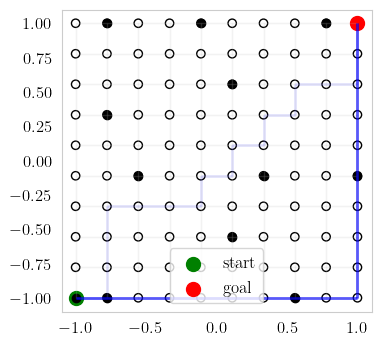

Acq optimizer x_next = (69, [59, 68, 79])
Finished iter i = 11
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 100 vertices with estimated cost 3.576014813689472
Found goal after visiting 100 vertices with estimated cost 3.6157511336961985
Found goal after visiting 100 vertices with estimated cost 3.6886245955322257
Found goal after visiting 100 vertices with estimated cost 3.6357451585092018
Found goal after visiting 100 vertices with estimated cost 3.660682485539279
Found goal after visiting 100 vertices with estimated cost 3.731652672523431
Found goal after visiting 100 vertices with estimated cost 3.71763536705314
Found goal after visiting 100 vertices with estimated cost 3.61512181430055
Found goal after visiting 100 vertices with estimated cost 3.6285814488596104
Found goal after visiting 100 vertices with estimated cost 3.679634005709383
*[TIME] [Sample 10 execution p

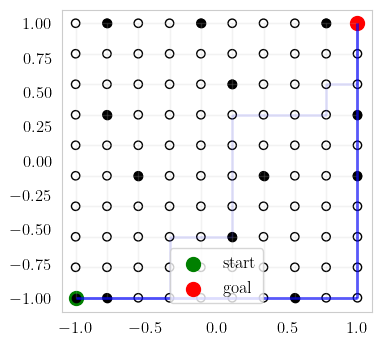

Acq optimizer x_next = (9, [8, 19])
Finished iter i = 12
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 100 vertices with estimated cost 3.7428256785254925
Found goal after visiting 100 vertices with estimated cost 3.7895302659419845
Found goal after visiting 100 vertices with estimated cost 3.8072326297832024
Found goal after visiting 100 vertices with estimated cost 3.7648566235088574
Found goal after visiting 100 vertices with estimated cost 3.7031981531587643
Found goal after visiting 100 vertices with estimated cost 3.776560002307139
Found goal after visiting 100 vertices with estimated cost 3.667684973753728
Found goal after visiting 100 vertices with estimated cost 3.737747533610355
Found goal after visiting 100 vertices with estimated cost 3.655636661583684
Found goal after visiting 100 vertices with estimated cost 3.785163277156536
*[TIME] [Sample 10 execution path

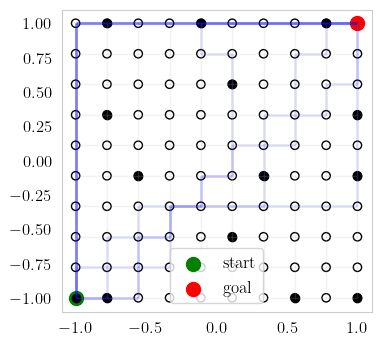

Acq optimizer x_next = (67, [57, 66, 68, 77])
Finished iter i = 13
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 100 vertices with estimated cost 3.7714580420759143
Found goal after visiting 100 vertices with estimated cost 3.760968910272421
Found goal after visiting 100 vertices with estimated cost 3.7517773775390224
Found goal after visiting 100 vertices with estimated cost 3.6831979118496023
Found goal after visiting 100 vertices with estimated cost 3.716525860247173
Found goal after visiting 100 vertices with estimated cost 3.7349364295899976
Found goal after visiting 100 vertices with estimated cost 3.7816105120826293
Found goal after visiting 100 vertices with estimated cost 3.7421489380717743
Found goal after visiting 100 vertices with estimated cost 3.76363342936009
Found goal after visiting 100 vertices with estimated cost 3.6552605559124185
*[TIME] [Sample 10 exe

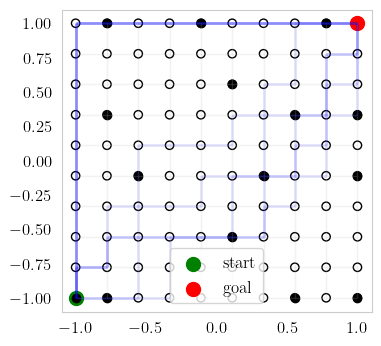

Acq optimizer x_next = (34, [24, 33, 35, 44])
Finished iter i = 14
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 100 vertices with estimated cost 3.6668690941942046
Found goal after visiting 100 vertices with estimated cost 3.7469700454560533
Found goal after visiting 100 vertices with estimated cost 3.704931939984597
Found goal after visiting 100 vertices with estimated cost 3.7378103529475295
Found goal after visiting 100 vertices with estimated cost 3.7404558506963665
Found goal after visiting 100 vertices with estimated cost 3.634767167424858
Found goal after visiting 100 vertices with estimated cost 3.7141392694884257
Found goal after visiting 100 vertices with estimated cost 3.7269350256739457
Found goal after visiting 100 vertices with estimated cost 3.756880118464963
Found goal after visiting 100 vertices with estimated cost 3.736737932232284
*[TIME] [Sample 10 exe

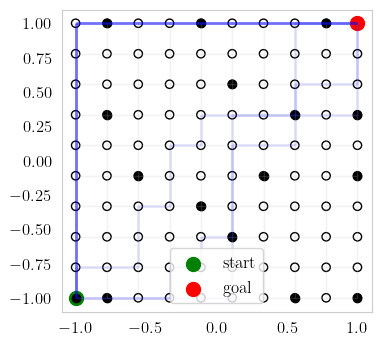

Acq optimizer x_next = (73, [63, 72, 74, 83])
Finished iter i = 15
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 100 vertices with estimated cost 3.768577131214741
Found goal after visiting 100 vertices with estimated cost 3.7672467493975486
Found goal after visiting 100 vertices with estimated cost 3.748232682104912
Found goal after visiting 100 vertices with estimated cost 3.7243804407930026
Found goal after visiting 100 vertices with estimated cost 3.783649305651141
Found goal after visiting 100 vertices with estimated cost 3.767313801714139
Found goal after visiting 100 vertices with estimated cost 3.7117117883376194
Found goal after visiting 100 vertices with estimated cost 3.7010375220068488
Found goal after visiting 100 vertices with estimated cost 3.7396619165491076
Found goal after visiting 100 vertices with estimated cost 3.6980007860102155
*[TIME] [Sample 10 exe

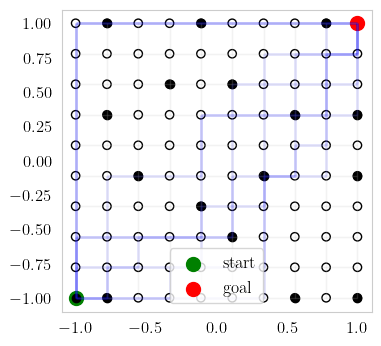

Acq optimizer x_next = (12, [2, 11, 13, 22])
Finished iter i = 16
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 100 vertices with estimated cost 3.721463640253726
Found goal after visiting 100 vertices with estimated cost 3.792651636101416
Found goal after visiting 100 vertices with estimated cost 3.7009008305362077
Found goal after visiting 100 vertices with estimated cost 3.8130287453609557
Found goal after visiting 100 vertices with estimated cost 3.706521268835156
Found goal after visiting 100 vertices with estimated cost 3.716621787524515
Found goal after visiting 100 vertices with estimated cost 3.75464168771216
Found goal after visiting 100 vertices with estimated cost 3.737390951889333
Found goal after visiting 100 vertices with estimated cost 3.756742299418501
Found goal after visiting 100 vertices with estimated cost 3.7741239255917325
*[TIME] [Sample 10 executio

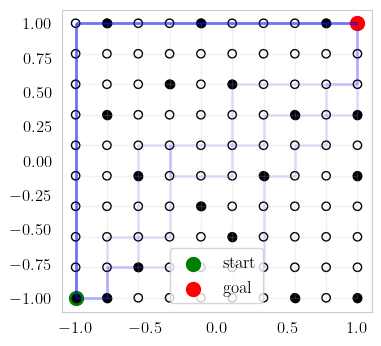

Acq optimizer x_next = (96, [86, 95, 97])
Finished iter i = 17
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 100 vertices with estimated cost 3.731262364498808
Found goal after visiting 100 vertices with estimated cost 3.745685324688555
Found goal after visiting 100 vertices with estimated cost 3.751410822624188
Found goal after visiting 100 vertices with estimated cost 3.715932230049594
Found goal after visiting 100 vertices with estimated cost 3.758332986727476
Found goal after visiting 100 vertices with estimated cost 3.7460307256469942
Found goal after visiting 100 vertices with estimated cost 3.744901694751265
Found goal after visiting 100 vertices with estimated cost 3.7322031896650483
Found goal after visiting 100 vertices with estimated cost 3.7863117751332833
Found goal after visiting 100 vertices with estimated cost 3.755979156391937
*[TIME] [Sample 10 execution 

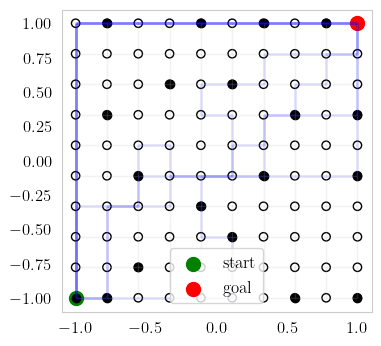

Acq optimizer x_next = (60, [50, 61, 70])
Finished iter i = 18
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 100 vertices with estimated cost 3.7619441343260545
Found goal after visiting 100 vertices with estimated cost 3.8212742643295305
Found goal after visiting 100 vertices with estimated cost 3.775623819584239
Found goal after visiting 100 vertices with estimated cost 3.79311248995601
Found goal after visiting 100 vertices with estimated cost 3.794217703271613
Found goal after visiting 100 vertices with estimated cost 3.727257841114551
Found goal after visiting 100 vertices with estimated cost 3.776942040109139
Found goal after visiting 100 vertices with estimated cost 3.7976280179839534
Found goal after visiting 100 vertices with estimated cost 3.756423281805702
Found goal after visiting 100 vertices with estimated cost 3.770131557404979
*[TIME] [Sample 10 execution p

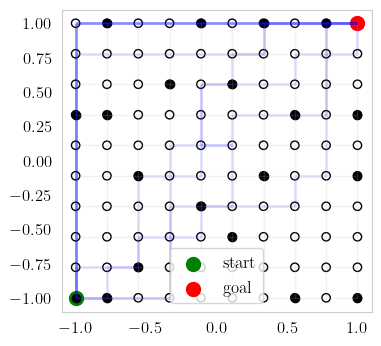

Acq optimizer x_next = (15, [5, 14, 16, 25])
Finished iter i = 19
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 100 vertices with estimated cost 3.7282611952592504
Found goal after visiting 100 vertices with estimated cost 3.758376169924345
Found goal after visiting 100 vertices with estimated cost 3.7291810543562454
Found goal after visiting 100 vertices with estimated cost 3.80369639469989
Found goal after visiting 100 vertices with estimated cost 3.690523475574052
Found goal after visiting 100 vertices with estimated cost 3.7213817980363477
Found goal after visiting 100 vertices with estimated cost 3.7772260580599823
Found goal after visiting 100 vertices with estimated cost 3.7206868997091704
Found goal after visiting 100 vertices with estimated cost 3.6923139323462397
Found goal after visiting 100 vertices with estimated cost 3.7698488308505715
*[TIME] [Sample 10 exec

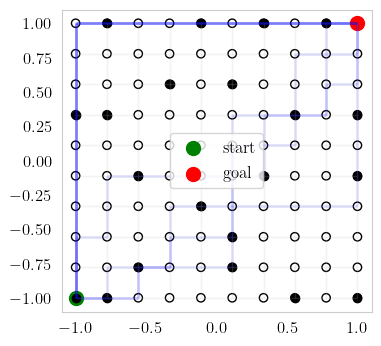

Acq optimizer x_next = (28, [18, 27, 29, 38])
Finished iter i = 20
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 100 vertices with estimated cost 3.8082854790814498
Found goal after visiting 100 vertices with estimated cost 3.8147242972348017
Found goal after visiting 100 vertices with estimated cost 3.807772805712708
Found goal after visiting 100 vertices with estimated cost 3.7511091708947495
Found goal after visiting 100 vertices with estimated cost 3.737540215084502
Found goal after visiting 100 vertices with estimated cost 3.7899279476501455
Found goal after visiting 100 vertices with estimated cost 3.718650426864066
Found goal after visiting 100 vertices with estimated cost 3.7086712695327173
Found goal after visiting 100 vertices with estimated cost 3.7605334960046846
Found goal after visiting 100 vertices with estimated cost 3.7365784885721713
*[TIME] [Sample 10 ex

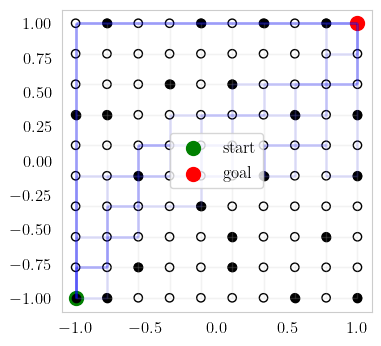

Acq optimizer x_next = (31, [21, 30, 32, 41])
Finished iter i = 21
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 100 vertices with estimated cost 3.8003518329632975
Found goal after visiting 100 vertices with estimated cost 3.762281549901522
Found goal after visiting 100 vertices with estimated cost 3.7705810052825965
Found goal after visiting 100 vertices with estimated cost 3.751393673689358
Found goal after visiting 100 vertices with estimated cost 3.750241830989202
Found goal after visiting 100 vertices with estimated cost 3.7776322401160156
Found goal after visiting 100 vertices with estimated cost 3.7331537857376835
Found goal after visiting 100 vertices with estimated cost 3.7714369994103247
Found goal after visiting 100 vertices with estimated cost 3.813464456662397
Found goal after visiting 100 vertices with estimated cost 3.7680118818707733
*[TIME] [Sample 10 exe

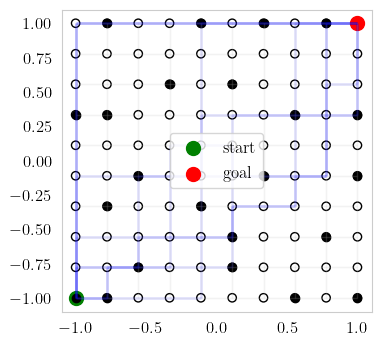

Acq optimizer x_next = (53, [43, 52, 54, 63])
Finished iter i = 22
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 100 vertices with estimated cost 3.8372509974847366
Found goal after visiting 100 vertices with estimated cost 3.7837546271586975
Found goal after visiting 100 vertices with estimated cost 3.7792266408245716
Found goal after visiting 100 vertices with estimated cost 3.773550757808824
Found goal after visiting 100 vertices with estimated cost 3.783515192817526
Found goal after visiting 100 vertices with estimated cost 3.8126028370866765
Found goal after visiting 100 vertices with estimated cost 3.7238072527596984
Found goal after visiting 100 vertices with estimated cost 3.7963450355384927
Found goal after visiting 100 vertices with estimated cost 3.738339399013068
Found goal after visiting 100 vertices with estimated cost 3.7244296179912553
*[TIME] [Sample 10 ex

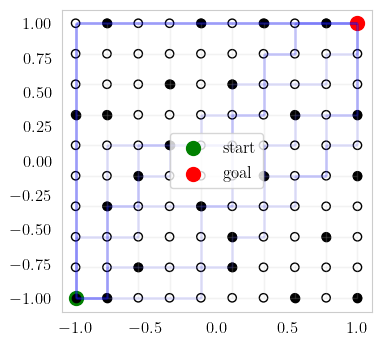

Acq optimizer x_next = (56, [46, 55, 57, 66])
Finished iter i = 23
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 100 vertices with estimated cost 3.770444185749648
Found goal after visiting 100 vertices with estimated cost 3.790123221893128
Found goal after visiting 100 vertices with estimated cost 3.7105170507647003
Found goal after visiting 100 vertices with estimated cost 3.786114045648109
Found goal after visiting 100 vertices with estimated cost 3.7652846951557453
Found goal after visiting 100 vertices with estimated cost 3.72324289692174
Found goal after visiting 100 vertices with estimated cost 3.7860472004672827
Found goal after visiting 100 vertices with estimated cost 3.7543022629962572
Found goal after visiting 100 vertices with estimated cost 3.7904394984152594
Found goal after visiting 100 vertices with estimated cost 3.738823069300763
*[TIME] [Sample 10 execu

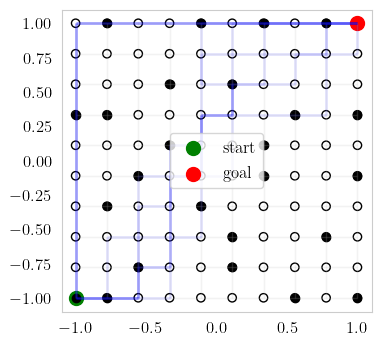

Acq optimizer x_next = (75, [65, 74, 76, 85])
Finished iter i = 24
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 100 vertices with estimated cost 3.6744403470997016
Found goal after visiting 100 vertices with estimated cost 3.7686410254542726
Found goal after visiting 100 vertices with estimated cost 3.784669702085477
Found goal after visiting 100 vertices with estimated cost 3.713297262053782
Found goal after visiting 100 vertices with estimated cost 3.787070366411589
Found goal after visiting 100 vertices with estimated cost 3.7666133467081355
Found goal after visiting 100 vertices with estimated cost 3.7712105479216165
Found goal after visiting 100 vertices with estimated cost 3.7819592812705802
Found goal after visiting 100 vertices with estimated cost 3.759920594465324
Found goal after visiting 100 vertices with estimated cost 3.74417931614974
*[TIME] [Sample 10 execu

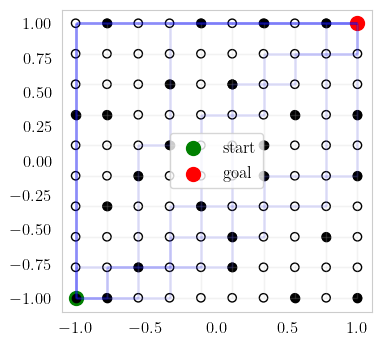

Acq optimizer x_next = (78, [68, 77, 79, 88])
Finished iter i = 25
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 100 vertices with estimated cost 3.7457180595979738
Found goal after visiting 100 vertices with estimated cost 3.776180853565584
Found goal after visiting 100 vertices with estimated cost 3.7771644621597176
Found goal after visiting 100 vertices with estimated cost 3.8116816409290273
Found goal after visiting 100 vertices with estimated cost 3.7856044795277017
Found goal after visiting 100 vertices with estimated cost 3.7827214670525153
Found goal after visiting 100 vertices with estimated cost 3.7827115145341175
Found goal after visiting 100 vertices with estimated cost 3.7778048902530452
Found goal after visiting 100 vertices with estimated cost 3.7521319362858567
Found goal after visiting 100 vertices with estimated cost 3.751200903748674
*[TIME] [Sample 10 e

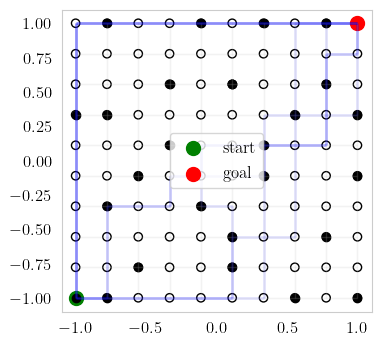

Acq optimizer x_next = (0, [1, 10])
Finished iter i = 26
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 100 vertices with estimated cost 3.871308947168993
Found goal after visiting 100 vertices with estimated cost 3.7533328577694753
Found goal after visiting 100 vertices with estimated cost 3.7874635282142677
Found goal after visiting 100 vertices with estimated cost 3.8600797366915947
Found goal after visiting 100 vertices with estimated cost 3.7715264851300976
Found goal after visiting 100 vertices with estimated cost 3.798644805517429
Found goal after visiting 100 vertices with estimated cost 3.7836567747614582
Found goal after visiting 100 vertices with estimated cost 3.7570460471736253
Found goal after visiting 100 vertices with estimated cost 3.844850089886232
Found goal after visiting 100 vertices with estimated cost 3.8375044271204644
*[TIME] [Sample 10 execution pa

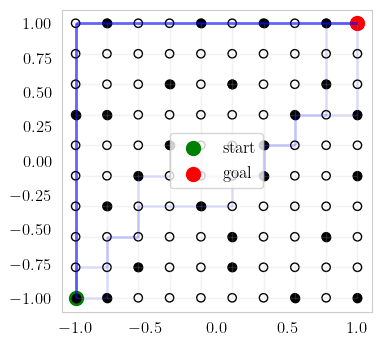

Acq optimizer x_next = (37, [27, 36, 38, 47])
Finished iter i = 27
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 100 vertices with estimated cost 3.8637311593455745
Found goal after visiting 100 vertices with estimated cost 3.804903851145036
Found goal after visiting 100 vertices with estimated cost 3.8355569691106357
Found goal after visiting 100 vertices with estimated cost 3.834056660165106
Found goal after visiting 100 vertices with estimated cost 3.7925764989304036
Found goal after visiting 100 vertices with estimated cost 3.75182539466438
Found goal after visiting 100 vertices with estimated cost 3.789675715806789
Found goal after visiting 100 vertices with estimated cost 3.8358935321772756
Found goal after visiting 100 vertices with estimated cost 3.811547928668376
Found goal after visiting 100 vertices with estimated cost 3.7925214059042
*[TIME] [Sample 10 executio

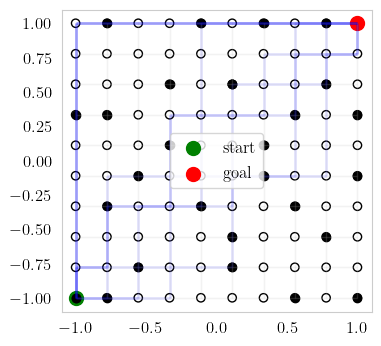

Acq optimizer x_next = (90, [80, 91])
Finished iter i = 28
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 100 vertices with estimated cost 3.8504077820172666
Found goal after visiting 100 vertices with estimated cost 3.8322747211904686
Found goal after visiting 100 vertices with estimated cost 3.8165289495380534
Found goal after visiting 100 vertices with estimated cost 3.8452696137469564
Found goal after visiting 100 vertices with estimated cost 3.806831979649002
Found goal after visiting 100 vertices with estimated cost 3.8435522917966853
Found goal after visiting 100 vertices with estimated cost 3.8063689491742703
Found goal after visiting 100 vertices with estimated cost 3.812429742701294
Found goal after visiting 100 vertices with estimated cost 3.8139984485599787
Found goal after visiting 100 vertices with estimated cost 3.831635210643937
*[TIME] [Sample 10 execution 

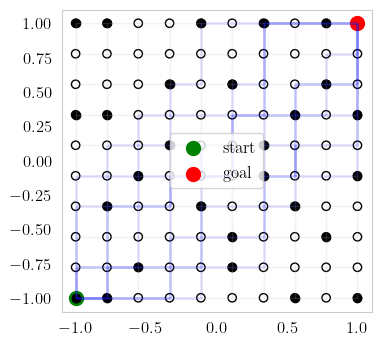

Acq optimizer x_next = (23, [13, 22, 24, 33])
Finished iter i = 29
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 100 vertices with estimated cost 3.8129887340044615
Found goal after visiting 100 vertices with estimated cost 3.8243106526175095
Found goal after visiting 100 vertices with estimated cost 3.81996537001063
Found goal after visiting 100 vertices with estimated cost 3.8206699219891007
Found goal after visiting 100 vertices with estimated cost 3.8551258813763614
Found goal after visiting 100 vertices with estimated cost 3.829125086644176
Found goal after visiting 100 vertices with estimated cost 3.8320606258944943
Found goal after visiting 100 vertices with estimated cost 3.839598107593803
Found goal after visiting 100 vertices with estimated cost 3.8461355151927323
Found goal after visiting 100 vertices with estimated cost 3.858790276870911
*[TIME] [Sample 10 exec

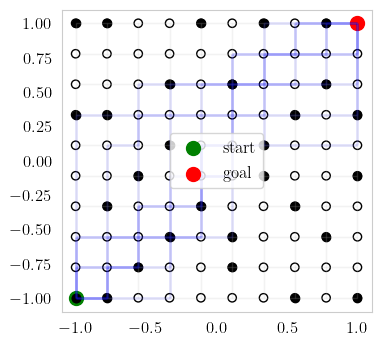

Acq optimizer x_next = (62, [52, 61, 63, 72])
Finished iter i = 30
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 100 vertices with estimated cost 3.821600757157217
Found goal after visiting 100 vertices with estimated cost 3.823862446802587
Found goal after visiting 100 vertices with estimated cost 3.8335682796581922
Found goal after visiting 100 vertices with estimated cost 3.8249118162588474
Found goal after visiting 100 vertices with estimated cost 3.8108546475207628
Found goal after visiting 100 vertices with estimated cost 3.813075471924911
Found goal after visiting 100 vertices with estimated cost 3.839420390460955
Found goal after visiting 100 vertices with estimated cost 3.850112166204951
Found goal after visiting 100 vertices with estimated cost 3.831993364157246
Found goal after visiting 100 vertices with estimated cost 3.8418408017529564
*[TIME] [Sample 10 execu

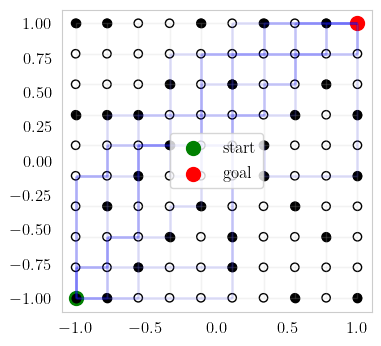

Acq optimizer x_next = (44, [34, 43, 45, 54])
Finished iter i = 31
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 100 vertices with estimated cost 3.841621434272801
Found goal after visiting 100 vertices with estimated cost 3.825353044813326
Found goal after visiting 100 vertices with estimated cost 3.82409385899828
Found goal after visiting 100 vertices with estimated cost 3.838835702951635
Found goal after visiting 100 vertices with estimated cost 3.8176522939301534
Found goal after visiting 100 vertices with estimated cost 3.8535431717575954
Found goal after visiting 100 vertices with estimated cost 3.826454214114193
Found goal after visiting 100 vertices with estimated cost 3.814596063041062
Found goal after visiting 100 vertices with estimated cost 3.8320334596378522
Found goal after visiting 100 vertices with estimated cost 3.787411219216951
*[TIME] [Sample 10 executi

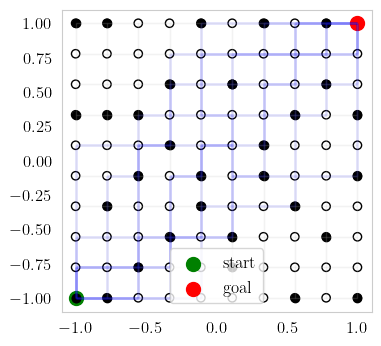

Acq optimizer x_next = (39, [29, 38, 49])
Finished iter i = 32
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 100 vertices with estimated cost 3.8395914234866977
Found goal after visiting 100 vertices with estimated cost 3.8707336653382973
Found goal after visiting 100 vertices with estimated cost 3.83553959880944
Found goal after visiting 100 vertices with estimated cost 3.8501805943208653
Found goal after visiting 100 vertices with estimated cost 3.826428329132696
Found goal after visiting 100 vertices with estimated cost 3.8478836933559526
Found goal after visiting 100 vertices with estimated cost 3.8107887640444114
Found goal after visiting 100 vertices with estimated cost 3.822991607583986
Found goal after visiting 100 vertices with estimated cost 3.8112694907908007
Found goal after visiting 100 vertices with estimated cost 3.8494653623953976
*[TIME] [Sample 10 executi

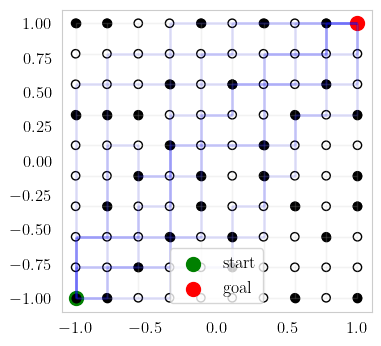

Acq optimizer x_next = (84, [74, 83, 85, 94])
Finished iter i = 33
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 100 vertices with estimated cost 3.892807935765849
Found goal after visiting 100 vertices with estimated cost 3.834088107317535
Found goal after visiting 100 vertices with estimated cost 3.85206915944135
Found goal after visiting 100 vertices with estimated cost 3.836282088572719
Found goal after visiting 100 vertices with estimated cost 3.838532167925652
Found goal after visiting 100 vertices with estimated cost 3.8497782753852765
Found goal after visiting 100 vertices with estimated cost 3.8257321732280722
Found goal after visiting 100 vertices with estimated cost 3.871476563265688
Found goal after visiting 100 vertices with estimated cost 3.8178654101438205
Found goal after visiting 100 vertices with estimated cost 3.85990030549753
*[TIME] [Sample 10 executio

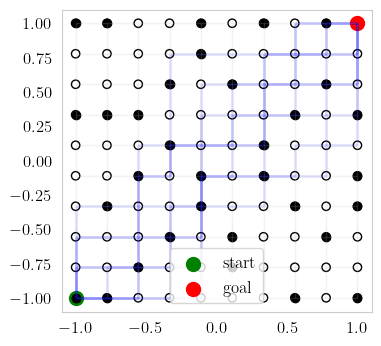

Acq optimizer x_next = (3, [2, 4, 13])
Finished iter i = 34
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 100 vertices with estimated cost 3.818449621619841
Found goal after visiting 100 vertices with estimated cost 3.849162557640762
Found goal after visiting 100 vertices with estimated cost 3.840599503385725
Found goal after visiting 100 vertices with estimated cost 3.8417880688132184
Found goal after visiting 100 vertices with estimated cost 3.8550280728879516
Found goal after visiting 100 vertices with estimated cost 3.8315241855833198
Found goal after visiting 100 vertices with estimated cost 3.838415300969345
Found goal after visiting 100 vertices with estimated cost 3.8098414735294304
Found goal after visiting 100 vertices with estimated cost 3.861270599200794
Found goal after visiting 100 vertices with estimated cost 3.849815561330104
*[TIME] [Sample 10 execution pa

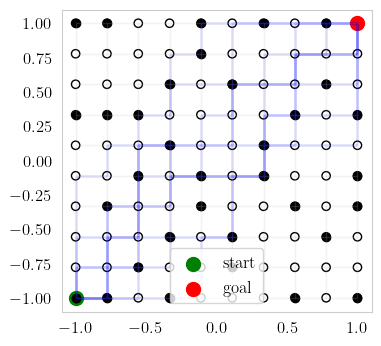

Acq optimizer x_next = (20, [10, 21, 30])
Finished iter i = 35
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 100 vertices with estimated cost 3.843164097782248
Found goal after visiting 100 vertices with estimated cost 3.8776213833780986
Found goal after visiting 100 vertices with estimated cost 3.856584783590034
Found goal after visiting 100 vertices with estimated cost 3.836598277148078
Found goal after visiting 100 vertices with estimated cost 3.857689504795534
Found goal after visiting 100 vertices with estimated cost 3.8583114631673556
Found goal after visiting 100 vertices with estimated cost 3.8651292425844597
Found goal after visiting 100 vertices with estimated cost 3.878812690482187
Found goal after visiting 100 vertices with estimated cost 3.838837392302627
Found goal after visiting 100 vertices with estimated cost 3.8577872796144037
*[TIME] [Sample 10 execution

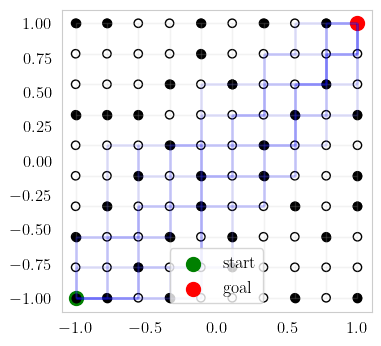

Acq optimizer x_next = (17, [7, 16, 18, 27])
Finished iter i = 36
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 100 vertices with estimated cost 3.8314824284775835
Found goal after visiting 100 vertices with estimated cost 3.8519662614729104
Found goal after visiting 100 vertices with estimated cost 3.8540689231722496
Found goal after visiting 100 vertices with estimated cost 3.843405839114072
Found goal after visiting 100 vertices with estimated cost 3.8334852592194295
Found goal after visiting 100 vertices with estimated cost 3.827572195380329
Found goal after visiting 100 vertices with estimated cost 3.841446469676045
Found goal after visiting 100 vertices with estimated cost 3.8659494522527007
Found goal after visiting 100 vertices with estimated cost 3.8362417055997198
Found goal after visiting 100 vertices with estimated cost 3.846133354784265
*[TIME] [Sample 10 exec

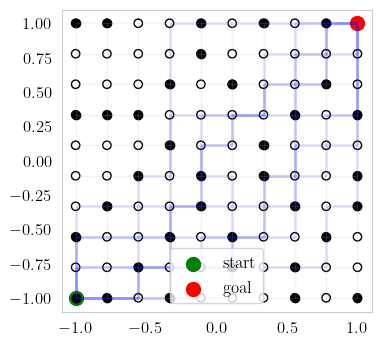

Acq optimizer x_next = (93, [83, 92, 94])
Finished iter i = 37
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 100 vertices with estimated cost 3.8016064209427087
Found goal after visiting 100 vertices with estimated cost 3.8663853008082105
Found goal after visiting 100 vertices with estimated cost 3.8524884920018128
Found goal after visiting 100 vertices with estimated cost 3.8297813863984906
Found goal after visiting 100 vertices with estimated cost 3.8408698661955976
Found goal after visiting 100 vertices with estimated cost 3.8566745842018264
Found goal after visiting 100 vertices with estimated cost 3.8501454797460397
Found goal after visiting 100 vertices with estimated cost 3.868599515497693
Found goal after visiting 100 vertices with estimated cost 3.8396152669516286
Found goal after visiting 100 vertices with estimated cost 3.8243776649354206
*[TIME] [Sample 10 exec

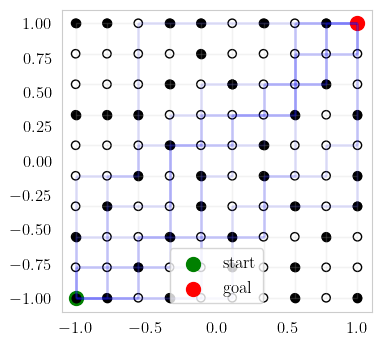

Acq optimizer x_next = (47, [37, 46, 48, 57])
Finished iter i = 38
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', parallel=False, viz_acq=False)
Found goal after visiting 100 vertices with estimated cost 3.8348925321350245
Found goal after visiting 100 vertices with estimated cost 3.8653069025774496
Found goal after visiting 100 vertices with estimated cost 3.799069693591725
Found goal after visiting 100 vertices with estimated cost 3.881141832839692
Found goal after visiting 100 vertices with estimated cost 3.821727824159324
Found goal after visiting 100 vertices with estimated cost 3.8513669842289513
Found goal after visiting 100 vertices with estimated cost 3.8252356885138297
Found goal after visiting 100 vertices with estimated cost 3.84594122416297
Found goal after visiting 100 vertices with estimated cost 3.841609674885862
Found goal after visiting 100 vertices with estimated cost 3.841297142980558
*[TIME] [Sample 10 execut

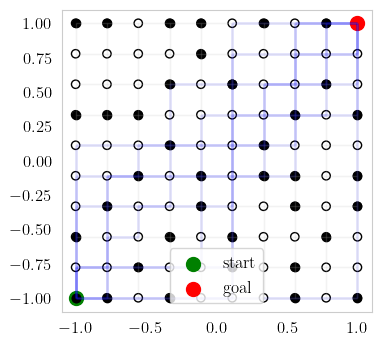

Acq optimizer x_next = (6, [5, 7, 16])
Finished iter i = 39


In [34]:
# BAX iterations
current_path = [start]
#x_test = possible_steps(start)
x_test = positions

import time


n_iter = 40

for i in range(n_iter):
    # Optimize acquisition function
    acqopt = AcqOptimizer({'n_path': 10,
                           'viz_acq': False})
    arg_x_next = acqopt.optimize(model, algo, x_test, return_argmax=True)

    # Query function, update data
    x_next = x_test[arg_x_next]
    y_next = f(x_next)
    data.x.append(x_next)
    data.y.append(y_next)
    
    # Update physical path taken
    #next_vertex = current_path[-1].neighbors[arg_x_next]
    next_vertex = vertices[arg_x_next]
    current_path.append(next_vertex)
    #print(f"Incurred true cost so far: {cost_of_path(current_path, cost_func)}")
    
    # Update next set of x_test    
    #x_test = possible_steps(next_vertex)

    # Update model
    model = SimpleGp(gp_params)
    model.set_data(data)
    
    fig, ax = plot_progress(edges, start, goal, current_path)
    plot_vertices(ax, current_path[:-1])
    
    last_outputs = acqopt.get_last_output_list()
    min_costs, min_cost_paths = zip(*last_outputs)
    n = acqopt.params.n_path
    for path in min_cost_paths:
        plot_path(ax, path, path_color=(0, 0, 1, 1/n), linewidths=2, linestyle="-")
    
    # make matplotlib plot within for loop. See: https://stackoverflow.com/questions/19766100/real-time-matplotlib-plot-is-not-working-while-still-in-a-loop
    plt.pause(0.0001)
    
    print(f'Acq optimizer x_next = {next_vertex}')
    print(f'Finished iter i = {i}')